In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    brier_score_loss
)

from sklearn.calibration import calibration_curve
import joblib


In [2]:
# Load trained calibrated model
model = joblib.load("../models/calibrated_logistic_v2.joblib")
feature_cols = joblib.load("../models/feature_columns_v2.joblib")


In [3]:
df = pd.read_csv("../data/processed/ml_training_data_v2.csv")

print(df.shape)
df.head()


(1169, 10)


,batting_diff,bowling_diff,overall_diff,recent_runs_diff,recent_wickets_diff,recent_econ_diff,toss_adv,home_adv,venue_win_rate_diff,team1_win
0,5.291662,8.260167,13.551830,2.854545,0.163636,-1.933563,-1,0,0.354167,1
1,-6.866101,-10.249467,-17.115568,-1.000000,0.254545,-1.131303,1,0,0.136364,1
2,-6.636761,-18.572381,-25.209142,4.472727,-0.095455,1.182283,-1,0,0.222222,0
3,2.537640,10.792871,13.330510,-6.100000,0.000000,1.046965,1,0,0.444444,1
4,-0.547613,-4.358547,-4.906160,0.745455,0.236364,1.455727,1,0,0.571429,1


In [4]:
from sklearn.model_selection import train_test_split

X = df[feature_cols]
y = df["team1_win"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape)
print("Test:", X_test.shape)


Train: (935, 9)
Test: (234, 9)


In [5]:
proba = model.predict_proba(X_test)[:,1]
pred = (proba >= 0.5).astype(int)

print("Accuracy:", round(accuracy_score(y_test, pred), 3))
print("AUC:", round(roc_auc_score(y_test, proba), 3))
print("\nClassification Report:\n")
print(classification_report(y_test, pred, digits=4))


Accuracy: 0.684
AUC: 0.758

Classification Report:

              precision    recall  f1-score   support

           0     0.7000    0.6525    0.6754       118
           1     0.6694    0.7155    0.6917       116

    accuracy                         0.6838       234
   macro avg     0.6847    0.6840    0.6836       234
weighted avg     0.6848    0.6838    0.6835       234



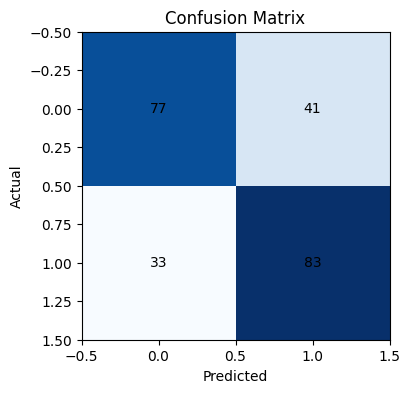

In [6]:
cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()


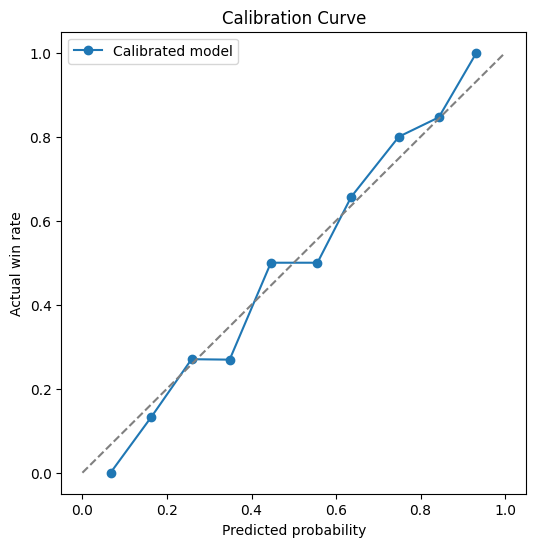

In [7]:
prob_true, prob_pred = calibration_curve(
    y_test, proba, n_bins=10
)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker="o", label="Calibrated model")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("Predicted probability")
plt.ylabel("Actual win rate")
plt.title("Calibration Curve")
plt.legend()
plt.show()


In [8]:
brier = brier_score_loss(y_test, proba)
print("Brier score:", round(brier, 4))


Brier score: 0.2003


In [9]:
# Pick random samples
idx = np.random.choice(len(X_test), 50, replace=False)

p1 = []
p2 = []

for i in idx:
    x = X_test.iloc[i]
    x_flip = -x.copy()

    p1.append(model.predict_proba(x.values.reshape(1,-1))[0,1])
    p2.append(model.predict_proba(x_flip.values.reshape(1,-1))[0,1])

print("Mean P(team1):", round(np.mean(p1),3))
print("Mean P(team2):", round(np.mean(p2),3))
print("Mean sum:", round(np.mean(np.array(p1)+np.array(p2)),3))


d:\ipl_win_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\ipl_win_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\ipl_win_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\ipl_win_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\ipl_win_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\ipl_win_predictor\.ven

Mean P(team1): 0.461
Mean P(team2): 0.437
Mean sum: 0.898


d:\ipl_win_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\ipl_win_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\ipl_win_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\ipl_win_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\ipl_win_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\ipl_win_predictor\.ven

In [11]:
# Take the first calibrated classifier
base_pipeline = model.calibrated_classifiers_[0].estimator

# Extract logistic regression coefficients
lr = base_pipeline.named_steps["lr"]
coefs = lr.coef_[0]

importance = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": coefs,
    "abs_importance": np.abs(coefs)
}).sort_values("abs_importance", ascending=False)

importance


,feature,coefficient,abs_importance
4,recent_wickets_diff,0.608633,0.608633
8,venue_win_rate_diff,0.494292,0.494292
3,recent_runs_diff,-0.386043,0.386043
5,recent_econ_diff,-0.331911,0.331911
7,home_adv,-0.304642,0.304642
0,batting_diff,0.238577,0.238577
6,toss_adv,0.068068,0.068068
2,overall_diff,0.058140,0.058140
1,bowling_diff,-0.035132,0.035132


In [12]:
errors = X_test.copy()
errors["actual"] = y_test.values
errors["pred_prob"] = proba
errors["pred"] = pred

# High confidence wrong predictions
bad = errors[
    ((errors["pred_prob"] > 0.8) & (errors["actual"] == 0)) |
    ((errors["pred_prob"] < 0.2) & (errors["actual"] == 1))
]

bad.head()


,batting_diff,bowling_diff,overall_diff,recent_runs_diff,recent_wickets_diff,recent_econ_diff,toss_adv,home_adv,venue_win_rate_diff,actual,pred_prob,pred
50,-3.389712,11.279488,7.889777,0.109091,-0.309091,1.961913,1,0,0.389831,1,0.197979,0
920,-3.029267,1.249770,-1.779497,-3.436364,0.300000,-1.540166,-1,0,0.354167,0,0.865328,1
81,-2.014608,-4.510002,-6.524610,-0.381818,-0.168182,-0.148442,-1,0,-0.555556,1,0.160242,0
452,6.438121,14.380974,20.819095,-6.550000,0.216667,-1.039529,-1,0,-0.263158,0,0.817005,1


In [13]:
coef_matrix = []

for c in model.calibrated_classifiers_:
    coef_matrix.append(c.estimator.named_steps["lr"].coef_[0])

coef_df = pd.DataFrame(coef_matrix, columns=feature_cols)
coef_df.std().sort_values(ascending=False)


recent_runs_diff       0.073792
recent_wickets_diff    0.057346
batting_diff           0.046598
recent_econ_diff       0.036780
toss_adv               0.034838
bowling_diff           0.029375
home_adv               0.020779
overall_diff           0.017531
venue_win_rate_diff    0.009950
dtype: float64